<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
#import contextily as ctx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states

root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Estimating Fire Casualties in NYC
In NYC, recent fires--like the fire that occurred recently in the Bronx, in which 17 people died--have been devasting. It is important for cities to develop better tools for understanding where such catastrophic events might occur and target these areas for better prevention measures. Specifically, while a building may receive numerous violations from the New York City Housing and Preservation Department (HPD), HPD in turn may not know which buildings to target and when such violations are serious.

I propose a predictive model that calculates the risk of a __catastrophic__ fire using variables not considered in other models.

* I incorporate water and electricity use, as a measure of crowding in the building.
* I use data on past violations in the building, as a measure of a negligent landlord.
* Data on median household income in the surrounding area.
* Population density in the surrounding area.
* Average daily temperature.
* Number of residential building units and building FAR.

# Load data on fire dispatch events
## From January 1st, 2017 through the present
* Create a plot of fire events each year
* Only structural fires are included


In [2]:
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=incident_datetime>="2017-01-01"%20AND%20INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(115079, 29)
115079


In [3]:
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)

## More fire events occur in late November, December, and early January

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Jennah\AppData\Local\Temp/ipykernel_35476/1594349092.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])


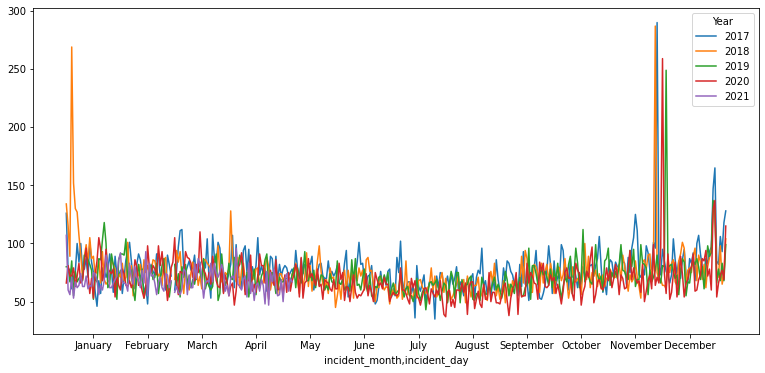

In [13]:
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

x = [(x, 15) for x in list(range(1,13))]

plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x is not ''])
plt.savefig(os.join(root, "figs/fire_ev_line.pdf"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

In [5]:
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=vacate_effective_date>="2017-01-01"%20AND%20primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(1512, 20)
1512


In [6]:
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

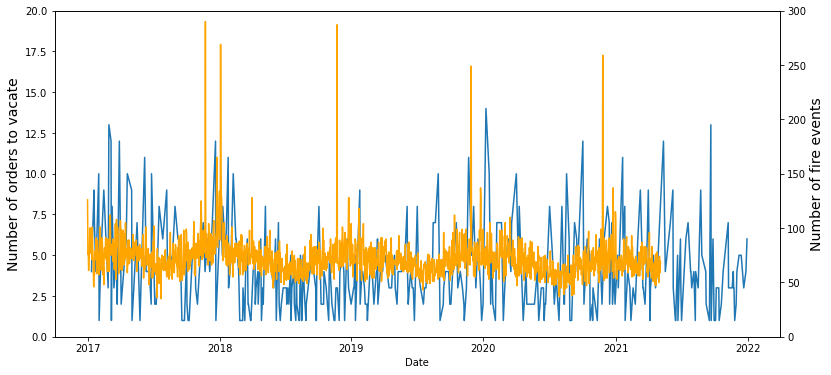

In [12]:
fig, ax = plt.subplots(figsize=(13, 6))
vac.loc[vac["vacate_effective_year"] < 2022, :].groupby("vacate_effective_date2").size().plot(ax = ax)
ax.set_ylabel("Number of orders to vacate", fontsize=14)
ax.set_ylim([0, 20])

# set second axis
ax2=ax.twinx()
fire_ev.groupby("incident_date").size().plot(ax = ax2, color = "orange")
ax2.set_ylabel("Number of fire events", fontsize=14)
ax2.set_ylim([0, 300])

ax.set_xlabel("Date")
plt.savefig(os.join(root, "figs/vac_line.pdf"))

In [8]:
## load pluto
pluto= gpd.read_file(os.join(root, "data/nyc_mappluto_21v4_shp/MapPLUTO.shp"))

In [24]:
vac_pluto= pluto.merge(vac, how = "inner", right_on = "bbl", left_on = "BBL")
vac_pluto

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,council_district,census_tract,bin,bbl,nta,vacate_effective_date2,vacate_effective_month,vacate_effective_day,vacate_effective_year,vacate_effective_md
0,MN,237,11,102,1004100,10041004001,41,4001,02,1,...,1,41,1077452.0,1.002370e+09,SoHo-TriBeCa-Civic Center-Little Italy,2018-02-28,2,28,2018,2-28
1,MN,239,11,102,1004100,10041002001,41,2001,02,1,...,1,41,1003119.0,1.002390e+09,SoHo-TriBeCa-Civic Center-Little Italy,2020-01-08,1,8,2020,1-8
2,MN,297,7501,103,1001600,10016005000,16,5000,02,1,...,1,16,1003827.0,1.002978e+09,Chinatown,2021-04-01,4,1,2021,4-1
3,MN,271,51,103,1000600,10006004001,6,4001,02,1,...,1,6,1003237.0,1.002710e+09,Lower East Side,2019-01-11,1,11,2019,1-11
4,MN,253,1,103,1000800,10008004000,8,4000,02,1,...,1,8,1077585.0,1.002530e+09,Chinatown ...,2017-11-17,11,17,2017,11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,SI,2922,1,501,5004003,50040032000,40,2000,31,49,...,49,40,5106237.0,5.029220e+09,Grymes Hill-Clifton-Fox Hills,2020-10-14,10,14,2020,10-14
1501,SI,3585,7502,502,5011402,50114022004,114.02,2004,31,50,...,50,11402,5109580.0,5.035858e+09,New Dorp-Midland Beach ...,2017-05-18,5,18,2017,5-18
1502,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2017-06-26,6,26,2017,6-26
1503,SI,3983,45,503,5012806,50128063000,128.06,3000,31,50,...,50,12806,5105548.0,5.039830e+09,Oakwood-Oakwood Beach,2020-10-14,10,14,2020,10-14


(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

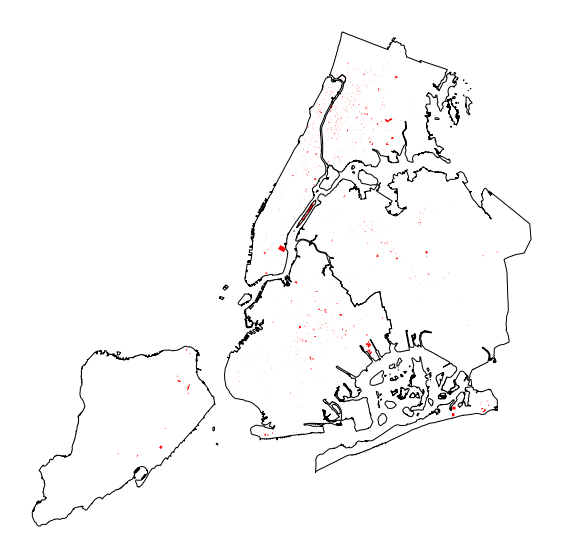

In [54]:
# load boros for background
boros= gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson').set_crs(4326).to_crs(2263)
fig,ax = plt.subplots(figsize=(15,10))

vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

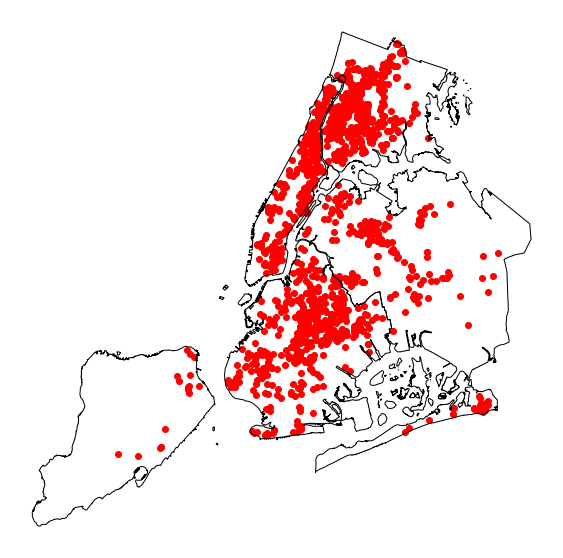

In [65]:
# convert to point data
#vac_pluto["geometry"]= vac_pluto["geometry"].representative_point()

fig,ax = plt.subplots(figsize=(15,10))
vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

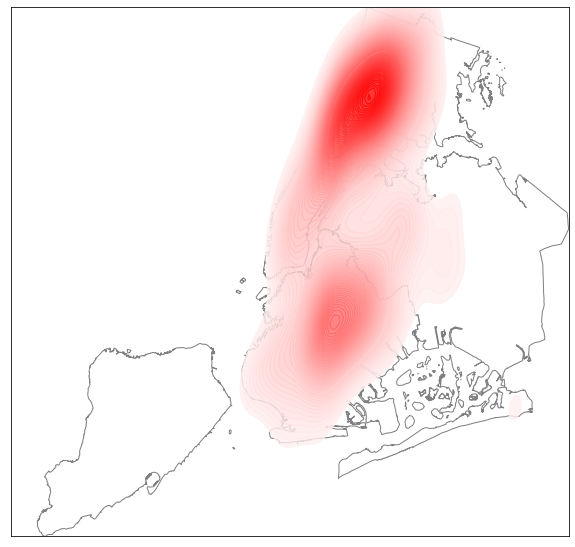

<Figure size 432x288 with 0 Axes>

In [175]:
# weight all the same
vac_pluto["weight"]= 1
# get extent
axis= boros.to_crs(4326).total_bounds
axis

# Calculate the KDE for heat map
data = np.c_[vac_pluto.longitude, vac_pluto.latitude]
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=vac_pluto.weight)

# Compute std along axis
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100

x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Create the map stretching over the requested area
ax = boros.to_crs(4326).plot(facecolor = 'none', edgecolor = 'gray',
                            figsize = (10, 10), alpha = 1)
cset = ax.contourf(xx, yy, levels,
    100,
    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 100, as_cmap=True),
    antialiased=True,
    alpha = 0.8
)
# Hide lowest 4 levels
for i in range(0,5):
    cset.collections[i].set_alpha(0)
    
# remove lines on contour map
for c in cset.collections:
    c.set_edgecolor("face")
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()
plt.savefig(os.join(root, "figs/heatmap.pdf"), dpi=300, bbox_inches='tight')

## Load census data

In [363]:
c = Census("41d7a1f4bba48dd0b6f9e5a08cc66f9949d81523", year=2019)

dict= {}
for count in ['061', '085', '081', '047', '005']:
    temp= c.acs5.get(('NAME', 'B19013_001E'),
              {'for': 'tract:*', 'in': 'state:{} county:{}'.format(states.NY.fips, count)})
    dict.update({(i["county"] + i["tract"]):i["B19013_001E"] for i in temp})

In [364]:
# create med hh inc df
medhhinc= pd.DataFrame({"GEOID": dict.keys(),
                        "Median HH Inc": dict.values()})

# load tract data
tracts= gpd.read_file("https://data.cityofnewyork.us/resource/i69b-3rdj.geojson?$limit=100000")
# recode geoid var for merging
tracts["GEOID"]= np.where(
     tracts['boro_code'] == "5", 
    "085"+tracts["ct2010"], 
     np.where(
        tracts['boro_code'] == "1", 
    "061"+tracts["ct2010"],
         np.where(
        tracts['boro_code'] == "4", 
        "081"+tracts["ct2010"],
             np.where(
                tracts['boro_code'] == "3", 
            "047"+tracts["ct2010"],
                 np.where(
                    tracts['boro_code'] == "5", 
                "005"+tracts["ct2010"], '99999999'
                 )
             )
         )
     )
)
tracts["GEOID"].unique()

,GEOID,Median HH Inc
0,061025500,66466.0
1,061022200,41250.0
2,061001001,81250.0
3,061000700,184609.0
4,061010300,96071.0
...,...,...
2162,005037504,20644.0
2163,005038301,43155.0
2164,005038302,20519.0
2165,005039500,29000.0


In [367]:
# merge tracts to census data
tracts_census= tracts.merge(medhhinc, how = "inner", on = "GEOID")
tracts_census

tracts_census['Median HH Inc']= np.where(
     tracts_census['Median HH Inc'] < 0, np.nan,
    tracts_census['Median HH Inc'])

(-74.28337047811618, -73.67222994890716, 40.476988784652164, 40.89818324976431)

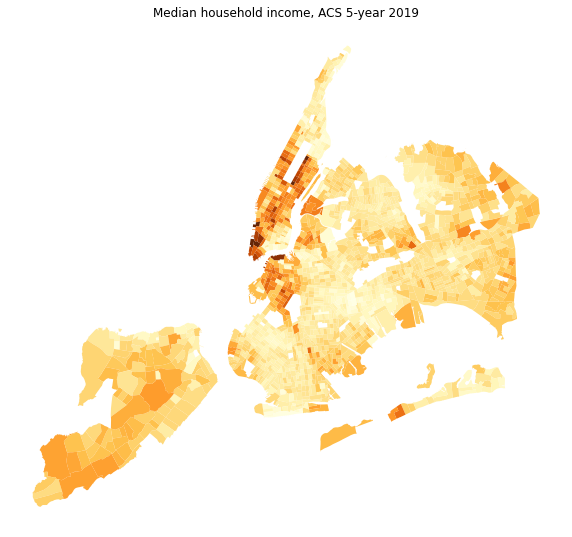

In [368]:
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "Median HH Inc", cmap = "YlOrBr", ax = ax)
plt.title("Median household income, ACS 5-year 2019")
ax.axis('off')